## Multiclass change detection with a UNet 

In [1]:
import torch 
import sys
sys.path.append('..')
from src.data.datamodules.binary_change import MultiClassChangeDetectionDataModule
from src.trainers.change import MultiClassChangeSemanticSegmentationTask
from src.trainers.utils import compute_class_weights_multiclass, calculate_class_frequencies, find_optimal_learning_rate, setup_training, compute_metrics_from_checkpoint
import torchgeo
import lightning as pl
import kornia
import matplotlib.pyplot as plt
import seaborn as sns
torchgeo.__version__, pl.__version__, torch.__version__, kornia.__version__

('0.7.0', '2.5.1', '2.6.0', '0.8.0')

In [2]:
# Define the input paths
image1_path='/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/flug_2003_rgb.tif'
image2_path='/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/flug_2013_rgb.tif'
mask_path='/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/habitalp_change_2003_2013_B_C_prio3_transitions_aggregated_rasterized.tif'
label_poly_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/habitalp_change_2003_2013_B_C_prio3_transitions_aggregated.gpkg'

# train_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_train_small.gpkg' # If Train ROI changes -> re-compute the class frequencies and weights!! 
# val_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_val_small.gpkg'
# test_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_test_small.gpkg'
train_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_train.gpkg' # If Train ROI changes -> re-compute the class frequencies and weights!! 
val_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_val.gpkg'
test_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_test.gpkg'

experiment_dir = '/home/hkristen/habitalp2/src/models/experiments'


In [3]:
#resnet 50 params - 512x512
# 20 minutes per epoch
patch_size = (512,512) 
batch_size = 24
num_workers = 4
learning_rate = 5e-4
backbone = 'resnet50'
num_classes = 10
min_epochs = 1
max_epochs = 150
patience = 30
samples_per_epoch = 25000
ignore_index = 0 #which class to ignore in loss/metrics
monitor_metric = "val_jaccard"

experiment_name = 'multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0'

logging = 'remote'
wandb_project = 'multiclass-change'
wandb_key = 'YOUR_WANDB_API_KEY_HERE'

In [4]:
torch.manual_seed(2)

datamodule = MultiClassChangeDetectionDataModule(
    image1_path=image1_path,
    image2_path=image2_path,
    mask_path=mask_path,
    train_roi_path=train_roi_path,
    val_roi_path=val_roi_path,
    test_roi_path=test_roi_path,
    label_poly_path=label_poly_path,
    num_classes=num_classes,  # This is the only additional parameter needed
    patch_size=patch_size,
    batch_size=batch_size,
    num_workers=num_workers,
    samples_per_epoch=samples_per_epoch
)
datamodule.setup()

/home/hkristen/habitalp2/notebooks/../src/data/datamodules/binary_change.py:85: RasterioDeprecationWarning: statistics() will be removed in 2.0.0. Please switch to stats().
  stats = src.statistics(band, approx=False)


Setting up datasets...
Datasets created successfully
Loaded 4480 valid label polygons.


Class mapping: {'Forest_Disturbance_Loss': 1, 'Clearcut_Loss': 2, 'Forest_Maturation_Gain': 3, 'Forest_to_Bare_Water': 4, 'Other_Transition': 5, 'Clearcut_Regeneration': 6, 'Forest_Conversion_GrassShrub': 7, 'Afforestation_Establishment': 8, None: 9}


Creating training dataloader with polygon intersection sampler
Unique mask values in this sample: [0 2 5]
Unique mask values in this sample: [0 2 3 6]
Unique mask values in this sample: [0 1]
Unique mask values in this sample: [0 2 3]


/home/hkristen/habitalp2/notebooks/../src/data/datamodules/binary_change.py:383: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x700 with 0 Axes>

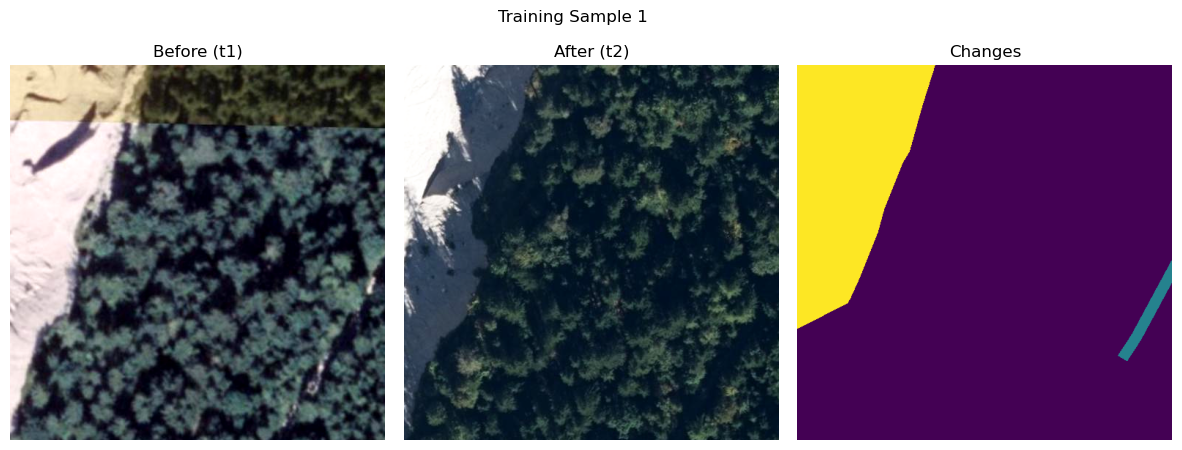

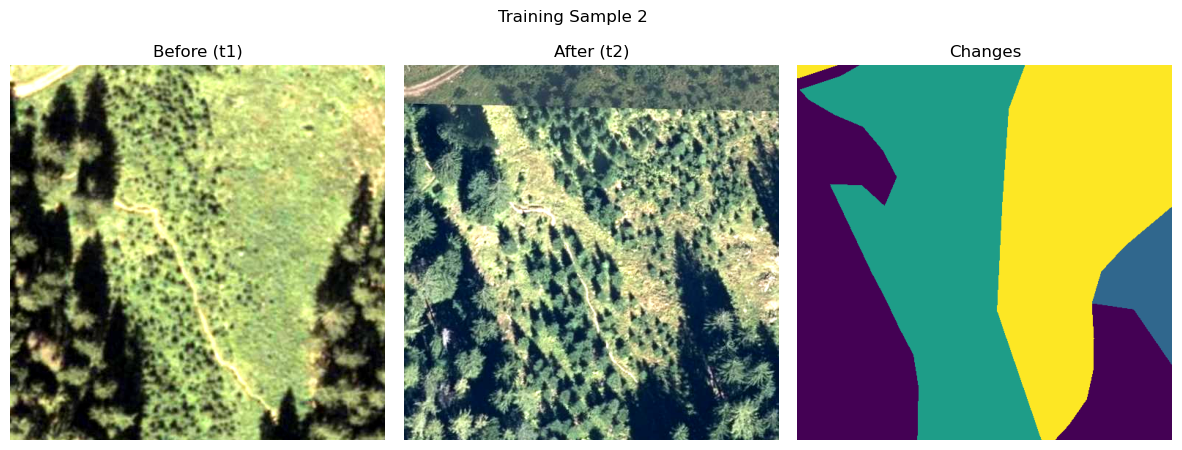

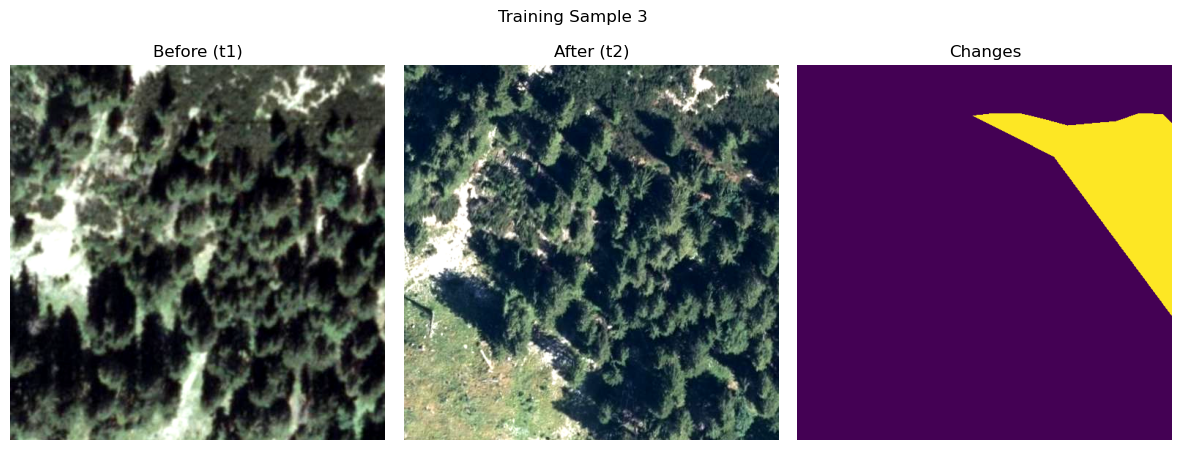

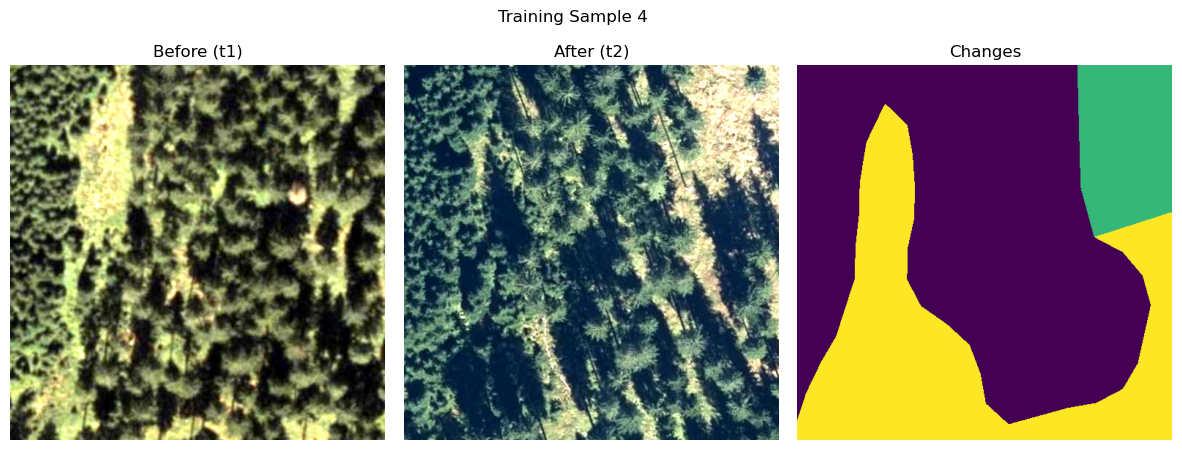

In [5]:
datamodule.visualize_samples()

In [6]:
# Calculate frequencies & weights 
class_pixel_counts = calculate_class_frequencies(datamodule, datamodule.num_classes)
class_weights = compute_class_weights_multiclass(class_pixel_counts)

Calculating class frequencies from training set...
Creating training dataloader with polygon intersection sampler
Total pixel counts per class: [4750835579  635041310  242291172  546796999   24573159  103423714
  199471549   30379495   19938295     848728]
Computed multi-class weights: [1.5892896e-03 1.1889705e-02 3.1162726e-02 1.3808514e-02 3.0726430e-01
 7.3005050e-02 3.7852287e-02 2.4853782e-01 3.7869102e-01 8.8961992e+00]


In [7]:
task = MultiClassChangeSemanticSegmentationTask(
    model="unet",
    backbone=backbone,
    weights=True,
    in_channels=6,
    num_classes=10,
    loss="ce",
    class_weights=class_weights,
    lr=learning_rate,
    ignore_index=0
)

In [8]:
gpu_id = 0
torch.set_float32_matmul_precision('high') #make use of tensor cores 


# Set up training
trainer = setup_training(
    experiment_name=experiment_name,
    experiment_dir=experiment_dir,
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    gpu_id=gpu_id,
    patience=patience,
    wandb_project=wandb_project,
    logging=logging,
    wandb_key=wandb_key,
    monitor_metric=monitor_metric
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hkristen/.netrc
wandb: Currently logged in as: hkristen (university-of-graz-geo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/hkristen/miniforge3/envs/geoai2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Setting up datasets...
Datasets created successfully


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded 4480 valid label polygons.
Creating training dataloader with polygon intersection sampler


Finding best initial lr:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=250` reached.
INFO: Learning rate set to 0.00046558609352295905
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00046558609352295905
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /home/hkristen/habitalp2/notebooks/.lr_find_b08ff4b4-8b87-444d-be76-5b0a12b2cdb6.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /home/hkristen/habitalp2/notebooks/.lr_find_b08ff4b4-8b87-444d-be76-5b0a12b2cdb6.ckpt


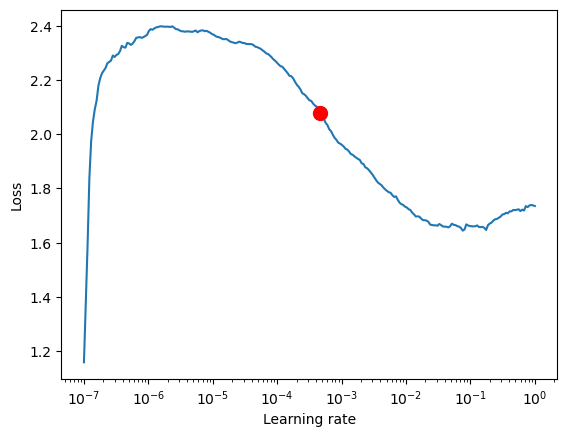

Suggested learning rate in scientifc notation:  5e-4


In [9]:
#suggested_lr, _ = find_optimal_learning_rate(task, datamodule, min_epochs, gpu_id)

In [18]:
_ = trainer.fit(model=task, datamodule=datamodule)

/home/hkristen/miniforge3/envs/geoai2/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Setting up datasets...
Datasets created successfully


/home/hkristen/miniforge3/envs/geoai2/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hkristen/habitalp2/src/models/experiments exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 32.5 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.127   Total estimated model params size (MB)
236       Modules in train mode
0         Modules in eval mode
INFO:lightn

Loaded 4480 valid label polygons.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Creating training dataloader with polygon intersection sampler


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_jaccard improved. New best score: 0.174
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_jaccard improved. New best score: 0.174
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1042: 'val_jaccard' reached 0.17356 (best 0.17356), saving model to '/home/hkristen/habitalp2/src/models/experiments/multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0-epoch=00-step=1042-val_jaccard=0.1736.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_jaccard improved by 0.015 >= min_delta = 0.0. New best score: 0.189
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_jaccard improved by 0.015 >= min_delta = 0.0. New best score: 0.189
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2084: 'val_jaccard' reached 0.18862 (best 0.18862), saving model to '/home/hkristen/habitalp2/src/models/experiments/multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0-epoch=01-step=2084-val_jaccard=0.1886.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_jaccard improved by 0.035 >= min_delta = 0.0. New best score: 0.224
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_jaccard improved by 0.035 >= min_delta = 0.0. New best score: 0.224
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3126: 'val_jaccard' reached 0.22365 (best 0.22365), saving model to '/home/hkristen/habitalp2/src/models/experiments/multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0-epoch=02-step=3126-val_jaccard=0.2236.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4168: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5210: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6252: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_jaccard improved by 0.005 >= min_delta = 0.0. New best score: 0.229
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_jaccard improved by 0.005 >= min_delta = 0.0. New best score: 0.229
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7294: 'val_jaccard' reached 0.22867 (best 0.22867), saving model to '/home/hkristen/habitalp2/src/models/experiments/multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0-epoch=06-step=7294-val_jaccard=0.2287.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_jaccard improved by 0.006 >= min_delta = 0.0. New best score: 0.235
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_jaccard improved by 0.006 >= min_delta = 0.0. New best score: 0.235
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8336: 'val_jaccard' reached 0.23496 (best 0.23496), saving model to '/home/hkristen/habitalp2/src/models/experiments/multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0-epoch=07-step=8336-val_jaccard=0.2350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9378: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10420: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 11462: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_jaccard improved by 0.027 >= min_delta = 0.0. New best score: 0.262
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_jaccard improved by 0.027 >= min_delta = 0.0. New best score: 0.262
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 12504: 'val_jaccard' reached 0.26174 (best 0.26174), saving model to '/home/hkristen/habitalp2/src/models/experiments/multiclass-change-2003-2013-03-resnet50_512x512_large_roi_IntersectingPolygons_JaccardStopping_ignore0-epoch=11-step=12504-val_jaccard=0.2617.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 13546: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 14588: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 15630: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 16672: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 17714: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 18756: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 19798: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 20840: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 21882: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 22924: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 23966: 'val_jaccard' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 25008: 'val_jaccard' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import os
os.system('shutdown now')

## Compute Confusion Matrix, Precision, Recall  

In [9]:
#add a block for reloading the compute_metrics_from_checkpoint

import importlib
import src.trainers.utils as utils_import
importlib.reload(utils_import)


<module 'src.trainers.utils' from '/home/hkristen/habitalp2/notebooks/../src/trainers/utils.py'>

Creating test dataloader with polygon intersection sampler


100%|██████████| 209/209 [01:25<00:00,  2.44it/s]


--- Weighted Average Metrics ---
Precision (Weighted): 0.0694
Recall (Weighted):    0.0389
F1 Score (Weighted):  0.0032


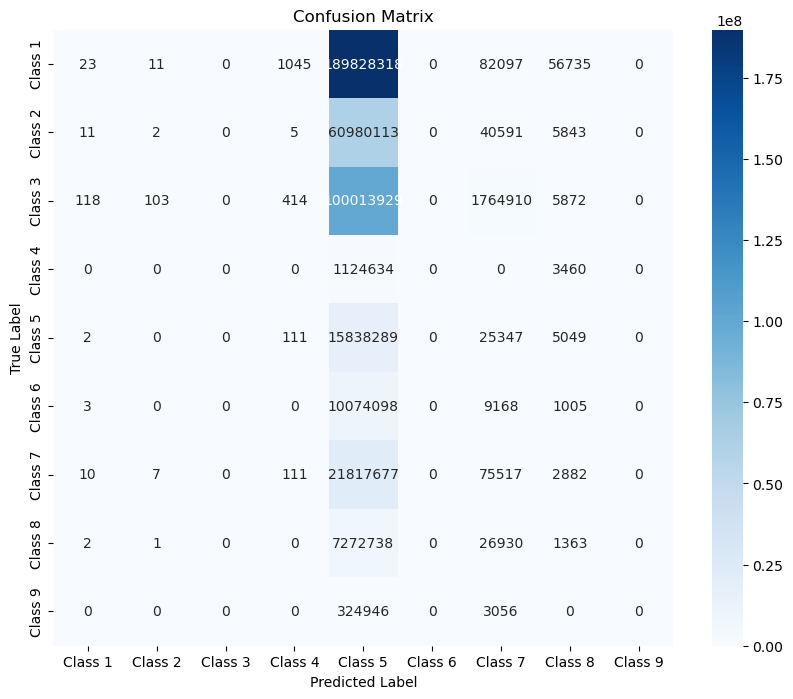


--- Per-Class Metrics ---
Class           Precision  Recall     F1-Score   Support   
-------------------------------------------------------
Class 1         0.1361     0.0000     0.0000     189968229 
Class 2         0.0161     0.0000     0.0000     61026565  
Class 3         0.0000     0.0000     0.0000     101785346 
Class 4         0.0000     0.0000     0.0000     1128094   
Class 5         0.0389     0.9981     0.0749     15868798  
Class 6         0.0000     0.0000     0.0000     10084274  
Class 7         0.0372     0.0034     0.0063     21896204  
Class 8         0.0166     0.0002     0.0004     7301034   
Class 9         0.0000     0.0000     0.0000     328002    
-------------------------------------------------------

Overall Accuracy: 0.0389


In [11]:
checkpoint_path = '/home/hkristen/habitalp2/src/models/experiments/last-v7.ckpt'
results = compute_metrics_from_checkpoint(checkpoint_path, datamodule, MultiClassChangeSemanticSegmentationTask, None)

# Print results
print("\n--- Weighted Average Metrics ---")
print(f"Precision (Weighted): {results['weighted_metrics']['precision']:.4f}")
print(f"Recall (Weighted):    {results['weighted_metrics']['recall']:.4f}")
print(f"F1 Score (Weighted):  {results['weighted_metrics']['f1']:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=results['class_names'], yticklabels=results['class_names'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print per-class metrics
print("\n--- Per-Class Metrics ---")
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 55)
for class_name, metrics in results['per_class_metrics'].items():
    print(f"{class_name:<15} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
          f"{metrics['f1']:<10.4f} {metrics['support']:<10}")
print("-" * 55)
print(f"\nOverall Accuracy: {results['accuracy']:.4f}")